In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from xgboost import XGBClassifier
import xgboost
from collections import Counter
from sklearn.pipeline import Pipeline
from currency_converter import CurrencyConverter
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
import warnings
import tensorflow as tf
import pickle
import joblib
import requests
import random
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

In [2]:
df_tn = pd.read_csv('data/financial_data_tunisia.csv', index_col=0)
df_tn = df_tn.drop_duplicates(subset=df_tn.columns)
df_tn.shape

(210, 10)

In [3]:
df_tn.head()

,sct,year,capitaux_propres,passifs_non_courant,total_bilan,stock,creance_client,actif_immobilier,resultat_net,chiffre_d_affaires
0,AB,2017,8.750900e+08,7.778707e+09,8.662590e+09,0.0,6.075063e+09,165955000.0,112493000.0,1.633735e+08
1,AB,2018,9.786010e+08,7.902909e+09,8.885599e+09,0.0,5.930429e+09,169076000.0,125280000.0,1.253033e+08
2,AB,2019,1.081664e+09,7.925654e+09,9.011329e+09,0.0,5.728896e+09,190413000.0,146556000.0,1.513254e+08
3,ADWYA,2017,3.903262e+07,7.252438e+06,9.057190e+07,27270466.0,1.828586e+07,34527355.0,4914454.0,2.002100e+07
4,ADWYA,2018,3.900292e+07,1.375171e+07,1.121328e+08,35229673.0,2.185274e+07,38819278.0,3122741.0,5.141764e+06


In [4]:
df = pd.read_csv('data/boursorama.csv', delimiter=';', index_col=False)
df = df.drop_duplicates(subset=df.columns)
df = df.replace({0.0 : np.nan})
df.shape

(672, 10)

In [5]:
df.head()

,sct,year,capitaux_propres,passifs_non_courant,total_bilan,stock,creance_client,actif_immobilier,resultat_net,chiffre_d_affaires
0,AB SCIENCE,12.17,10735.0,20381.0,50600.0,159.0,449.0,1910.0,-27122.0,1739.0
1,AB SCIENCE,12.18,-14962.0,17535.0,22491.0,153.0,236.0,1725.0,-26061.0,1701.0
2,AB SCIENCE,12.19,-26829.0,24226.0,17740.0,230.0,197.0,1610.0,-21747.0,1571.0
3,ABC ARBITRAGE,12.17,148867.0,NaN,153935.0,159.0,7217.0,1386.0,18309.0,NaN
4,ABC ARBITRAGE,12.18,146291.0,NaN,151983.0,153.0,8169.0,1161.0,19679.0,NaN


In [6]:
columns_with_nan = []
for column in df.columns:
    if df[column].isnull().values.any():
        columns_with_nan.append(column)
for column in columns_with_nan:
    df[column] = df.groupby('sct')[column].transform(lambda x: x.fillna(x.mean()))

In [7]:
df.isnull().sum().sum()

87

In [8]:
df.dropna(inplace=True)
df.shape

(594, 10)

In [9]:
chiffres_d_aff = []
for item in df['chiffre_d_affaires']:
    chiffres_d_aff.append(item)

In [10]:
def get_exchange_rate(base_currency, target_currency):

    if base_currency == target_currency:
        return 1

    api_uri = "http://data.fixer.io/api/latest?access_key=33b7f5ab7ef7e811a3bfa0e2d5e8d928&format=1?base={}&symbols={}".format(base_currency, target_currency)
    api_response = requests.get(api_uri)

    if api_response.status_code == 200:
        return api_response.json()["rates"][target_currency]

### Converting EUR data to TND

In [11]:
cols = [c for c in df.columns if c != 'sct' and c != 'year']

In [12]:
cols

['capitaux_propres',
 'passifs_non_courant',
 'total_bilan',
 'stock',
 'creance_client',
 'actif_immobilier',
 'resultat_net',
 'chiffre_d_affaires']

In [13]:
for col in df[cols]:
    print(col)

capitaux_propres
passifs_non_courant
total_bilan
stock
creance_client
actif_immobilier
resultat_net
chiffre_d_affaires


In [14]:
for col in df[cols]:
    df[col] =df[col] * 3.310807

In [15]:
df.head()

,sct,year,capitaux_propres,passifs_non_courant,total_bilan,stock,creance_client,actif_immobilier,resultat_net,chiffre_d_affaires
0,AB SCIENCE,12.17,3.554151e+04,6.747756e+04,1.675268e+05,526.418313,1.486552e+03,6.323641e+03,-8.979571e+04,5.757493e+03
1,AB SCIENCE,12.18,-4.953629e+04,5.805500e+04,7.446336e+04,506.553471,7.813505e+02,5.711142e+03,-8.628294e+04,5.631683e+03
2,AB SCIENCE,12.19,-8.882564e+04,8.020761e+04,5.873372e+04,761.485610,6.522290e+02,5.330399e+03,-7.200012e+04,5.201278e+03
6,ACCOR,12.17,1.928876e+07,9.164314e+06,3.998131e+07,26486.456000,1.334255e+06,9.813232e+06,1.592498e+06,6.413033e+06
7,ACCOR,12.18,2.133153e+07,9.137827e+06,4.295772e+07,49662.105000,2.042768e+06,1.402458e+07,7.561883e+06,1.086607e+07


## Merging dataframes

In [16]:
frames = [df, df_tn]
df_final = pd.concat(frames, ignore_index=True)

In [17]:
df_final.head()

,sct,year,capitaux_propres,passifs_non_courant,total_bilan,stock,creance_client,actif_immobilier,resultat_net,chiffre_d_affaires
0,AB SCIENCE,12.17,3.554151e+04,6.747756e+04,1.675268e+05,526.418313,1.486552e+03,6.323641e+03,-8.979571e+04,5.757493e+03
1,AB SCIENCE,12.18,-4.953629e+04,5.805500e+04,7.446336e+04,506.553471,7.813505e+02,5.711142e+03,-8.628294e+04,5.631683e+03
2,AB SCIENCE,12.19,-8.882564e+04,8.020761e+04,5.873372e+04,761.485610,6.522290e+02,5.330399e+03,-7.200012e+04,5.201278e+03
3,ACCOR,12.17,1.928876e+07,9.164314e+06,3.998131e+07,26486.456000,1.334255e+06,9.813232e+06,1.592498e+06,6.413033e+06
4,ACCOR,12.18,2.133153e+07,9.137827e+06,4.295772e+07,49662.105000,2.042768e+06,1.402458e+07,7.561883e+06,1.086607e+07


In [18]:
df_final.shape

(804, 10)

In [19]:
X = df_final.copy()
X['ratio_de_solvabilite'] = X['passifs_non_courant'] / X['capitaux_propres']
X['ratio_de_rentabilite'] = X['resultat_net'] / X['capitaux_propres']
X['ratio_d_endettement'] = (X['total_bilan'] - X['capitaux_propres']) / X['total_bilan']
X['marge_nette_sur_vente'] = (X['resultat_net'] / X['chiffre_d_affaires']) * 100
X['score'] = 0

In [20]:
score_list = []
for i in range(len(X['ratio_d_endettement'])):
    scr = 0
    if X['ratio_d_endettement'].iloc[i] < 1:
        scr = scr + 2.5
    if X['ratio_de_rentabilite'].iloc[i] >= 10 and X['ratio_de_rentabilite'].iloc[i] <= 20:
        scr = scr + 2
    if X['marge_nette_sur_vente'].iloc[i] >= 5 and X['marge_nette_sur_vente'].iloc[i] <= 10:
        scr = scr + 1.5
    if X['ratio_de_solvabilite'].iloc[i] < 1:
        scr = scr + 1
    score_list.append(scr)
final_score_list = []
for item in score_list:
    if item >= sum(score_list)/len(score_list):
        final_score_list.append(1)
    else:
        final_score_list.append(0)
X['score'] = final_score_list

In [21]:
approve = 0
reject = 0
for i in final_score_list:
    if i == 0:
        reject += 1
    else:
        approve += 1

In [22]:
y = X['score']
X.drop(axis=1, columns='score', inplace=True)

In [23]:
print('approved : {}, rejected : {}'.format(approve, reject))

approved : 602, rejected : 202


scaling data

In [24]:
x_cols = ['ratio_de_solvabilite',
 'ratio_de_rentabilite',
 'ratio_d_endettement',
 'marge_nette_sur_vente']

In [25]:
df_tn.to_csv('financial_data_tunisia.csv')

In [26]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    return model.score(X_test,y_test)

In [27]:
pipeline_s_lr = Pipeline([
    ('standard',StandardScaler()),
    ('lr_classifier',LogisticRegression())])

pipeline_s_svm = Pipeline([
    ('standard',StandardScaler()),
    ('svc',SVC())])

pipeline_s_xgb = Pipeline([
    ('standard',StandardScaler()),
    ('xgb',XGBClassifier())
    ])

pipeline_mm_lr = Pipeline([
    ('minmax',MinMaxScaler()),
    ('lr_classifier',LogisticRegression())])

pipeline_mm_svm = Pipeline([
    ('minmax',MinMaxScaler()),
    ('svc',SVC())])

pipeline_mm_xgb = Pipeline([
    ('minmax',MinMaxScaler()),
    ('xgb',XGBClassifier())
    ])

In [28]:
folds = StratifiedKFold(n_splits=10)
scores_s_lr = []
scores_s_svm = []
scores_s_xgb = []
scores_mm_lr = []
scores_mm_svm = []
scores_mm_xgb = []
for train_index, test_index in folds.split(X[x_cols],y):
    X_train, X_test, y_train, y_test = X[x_cols].to_numpy()[train_index], X[x_cols].to_numpy()[test_index], y.to_numpy()[train_index], y.to_numpy()[test_index]     
    scores_s_lr.append(get_score(pipeline_s_lr, X_train, X_test, y_train, y_test))
    scores_s_svm.append(get_score(pipeline_s_svm, X_train, X_test, y_train, y_test))
    scores_s_xgb.append(get_score(pipeline_s_xgb, X_train, X_test, y_train, y_test))
    scores_mm_lr.append(get_score(pipeline_mm_lr, X_train, X_test, y_train, y_test))
    scores_mm_svm.append(get_score(pipeline_mm_svm, X_train, X_test, y_train, y_test))
    scores_mm_xgb.append(get_score(pipeline_mm_xgb, X_train, X_test, y_train, y_test))

[15:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:21:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [29]:
print('Logistic regression standard scaler Score \t: ', sum(scores_s_lr)/len(scores_s_lr))
print('SVM Score standard scaler \t\t\t: ', sum(scores_s_svm)/len(scores_s_svm))
print('XGB Score standard scaler \t\t\t: ', sum(scores_s_xgb)/len(scores_s_xgb))
print('Logistic regression mm scaler Score \t: ', sum(scores_mm_lr)/len(scores_mm_lr))
print('SVM mm scaler Score \t\t\t: ', sum(scores_mm_svm)/len(scores_mm_svm))
print('XGB mm scaler Score \t\t\t: ', sum(scores_mm_xgb)/len(scores_mm_xgb))

Logistic regression standard scaler Score 	:  0.7674537037037037
SVM Score standard scaler 			:  0.7686728395061728
XGB Score standard scaler 			:  0.9987654320987656
Logistic regression mm scaler Score 	:  0.7512345679012344
SVM mm scaler Score 			:  0.7524537037037037
XGB mm scaler Score 			:  0.9987654320987656


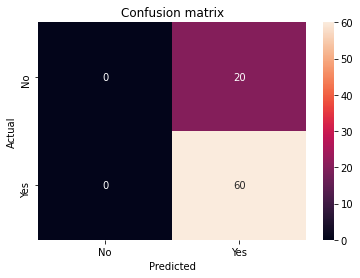

In [30]:
y_pred = pipeline_mm_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(["No","Yes"])
ax.yaxis.set_ticklabels(["No","Yes"])
plt.show()

### Model Tuning

In [31]:
params_lr = {
    'lr_classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'lr_classifier__C' : np.linspace(0,10,100),
    'lr_classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'lr_classifier__max_iter' : [100,1000,2000,3000]
}

In [32]:
clf = GridSearchCV(pipeline_mm_lr, param_grid = params_lr, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


In [33]:
best_clf.best_estimator_.score(X_test, y_test)

0.925

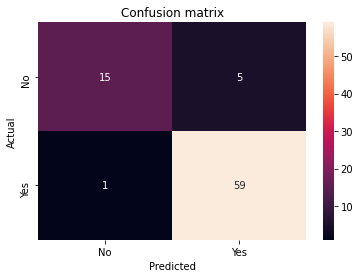

In [34]:
y_pred = best_clf.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(["No","Yes"])
ax.yaxis.set_ticklabels(["No","Yes"])
plt.show()

In [35]:
filename = 'loan_model_lr.pkl'
joblib.dump(best_clf.best_estimator_, filename)

['loan_model_lr.pkl']

### Deep learning model

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X[x_cols], y, test_size=0.2, random_state=1, shuffle=True)

In [44]:
classifier = Sequential()
X_train, X_test = np.asarray(X_train).astype('float32'), np.asarray(X_test).astype('float32')
classifier.add(Dense(400, activation='relu', kernel_initializer='random_normal', input_dim=X_test.shape[1]))
classifier.add(Dense(800, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(10, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, batch_size=20, epochs=100, verbose=2)
eval_mode = classifier.evaluate(X_train, y_train)
eval_mode

Epoch 1/100
33/33 - 1s - loss: 0.8350 - accuracy: 0.7107
Epoch 2/100
33/33 - 0s - loss: 0.6939 - accuracy: 0.7558
Epoch 3/100
33/33 - 0s - loss: 0.6747 - accuracy: 0.7574
Epoch 4/100
33/33 - 0s - loss: 0.6678 - accuracy: 0.7574
Epoch 5/100
33/33 - 0s - loss: 0.6613 - accuracy: 0.7574
Epoch 6/100
33/33 - 0s - loss: 0.6549 - accuracy: 0.7574
Epoch 7/100
33/33 - 0s - loss: 0.6491 - accuracy: 0.7574
Epoch 8/100
33/33 - 0s - loss: 0.6527 - accuracy: 0.7574
Epoch 9/100
33/33 - 0s - loss: 0.6390 - accuracy: 0.7574
Epoch 10/100
33/33 - 0s - loss: 0.6326 - accuracy: 0.7574
Epoch 11/100
33/33 - 0s - loss: 0.6397 - accuracy: 0.7574
Epoch 12/100
33/33 - 0s - loss: 0.6219 - accuracy: 0.7589
Epoch 13/100
33/33 - 0s - loss: 0.6170 - accuracy: 0.7589
Epoch 14/100
33/33 - 0s - loss: 0.6173 - accuracy: 0.7589
Epoch 15/100
33/33 - 0s - loss: 0.6112 - accuracy: 0.7558
Epoch 16/100
33/33 - 0s - loss: 0.6023 - accuracy: 0.7605
Epoch 17/100
33/33 - 0s - loss: 0.5855 - accuracy: 0.7605
Epoch 18/100
33/33 - 0s

[0.10024173557758331, 0.9595645666122437]

In [45]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred>=0.5)

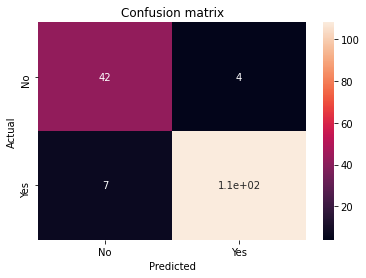

In [46]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(["No","Yes"])
ax.yaxis.set_ticklabels(["No","Yes"])
plt.show()

In [47]:
filename = 'loan_model_dl.pkl'
classifier.save('loan_model_dl.h5')